In [1]:
import mujoco as mj
import dm_control.mujoco
from mujoco import viewer
import random
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET




In [2]:
#### Evolutionary Algorithm
def evolution(xml, gen, bodies_per_gen, iterations_body):


    i=0 #generation iteration counter
    j=0 #body iteration counter
    
    best_body_fitness = 0
    best_body = 0
    
    best_gen_fitness = []
    gen_list = []
    xml_list = []
    best_specimen = []
    
    while i<gen:
        while j<bodies_per_gen:
            fitness = mutate(xml,i,j, iterations_body)                    #Mutate the model, simulate and determine the fitness of the model       
            xml_list.append(f"Gen{i}Body{j}.xml")
            if fitness > best_body_fitness:
                best_body_fitness = fitness
                best_body = j
            j+=1
            
        if j==bodies_per_gen:
            print(best_body_fitness, best_body)
            best_gen_fitness.append(best_body_fitness)
            
            if best_body_fitness > np.argmax(best_gen_fitness):              #Compare to fitness value of prev generations to see what the best evolution seed is
                xml = xml_list[best_body]
                best_specimen.append(best_body)
            j=0
            
        
        gen_list.append(i+1)
        #print(best_gen_fitness)
        xml_list = []  #reset values
        best_body_fitness = 0   
        best_body = 0
        
        i+=1
    
    print(best_gen_fitness)
    print(best_specimen)
    plot(gen_list, best_gen_fitness)


In [3]:
### MUTATE ###
def mutate(best_xml_file,i,j, iterations_body):

    num = random.uniform(0,1)
    print(num)
    if num<=0.5:
        
        tree = ET.parse(best_xml_file)
        root = tree.getroot()
    
        mujoco = ET.Element('mujoco')
        worldbody = ET.SubElement(mujoco, 'worldbody')
        light = ET.SubElement(worldbody, 'light', diffuse=".5 .5 .5", pos="0 0 3", dir="0 0 -1")
        plane = ET.SubElement(worldbody, 'geom', name="ground", type="plane", size="50 50 0.1", rgba=".9 .9 .9 1")
        actuator = ET.SubElement(mujoco, 'actuator')
        bodyframe= ET.SubElement(worldbody, 'body', name="geodude_body", pos="0 0 1") 
    
        joint_geodude = ET.SubElement(bodyframe, 'joint', type = "free")
        body_geodude = ET.SubElement(bodyframe, 'body', name = "main_body", pos = "0 0 0")
        geom_geodude = ET.SubElement(bodyframe, 'geom', type = "sphere", size = "0.12", rgba = "1 0 0 1", pos = "0 0 0", mass ="5")
    
        num_arms = 0
        arm_range = []
        arm_gear = []
        arm_mass = []
        
        
        for body in root.findall('.//body'):
            if body.get('name', '').startswith('arm'):
                num_arms+=1
    
        for body in root.findall('.//joint'):
            if body.get('name', '').startswith('arm'):
                arm_range.append(body.get('range'))
    
        for body in root.findall('.//motor'):
            if body.get('name', '').startswith('arm'):
                arm_gear.append(body.get('gear'))
    

        num_arms+=1
        count = 1
        pos0 = random.uniform(0,0.5)
        pos1 = random.uniform(0,0.5)
        pos2 = 0

        while count <= num_arms:
            if count == 1:
                pos0 = -0.2
                pos1 = 0
            elif count == 2:
                pos0 = 0.2
                pos1 = 0
            else:
                pos0 = random.uniform(-0.1,0.1)
                pos1 = random.uniform(-0.1,0.1)
            arm = ET.SubElement(bodyframe, 'body', name = "arm"+str(count), pos =f"{pos0} {pos1} {pos2}")
            #print("Success 1")       
            joint_geom = ET.SubElement(arm, 'geom', name="arm" + str(count), type="capsule", size="0.05 0.02",  rgba="0 1 0 1", mass="0.01")
            #print("Success 2")
            joint_hinge = ET.SubElement(arm, 'joint', name="arm" + str(count), type="hinge", axis="1 0 0")
            #print("Success 3")
            if count == 1:
                body_hand = ET.SubElement(arm, 'body', name = "hand" + str(count), pos = "-0.08 -0.05 0")
                geom_hand = ET.SubElement(body_hand, 'geom', type = "sphere", size = "0.03", rgba = "0 0 1 1", mass = "1")
            elif count == 2:
                body_hand = ET.SubElement(arm, 'body', name = "hand" + str(count), pos = "0.08 -0.05 0")
                geom_hand = ET.SubElement(body_hand, 'geom', type = "sphere", size = "0.03", rgba = "0 0 1 1", mass = "1")
                
            motor = ET.SubElement(actuator, 'motor', name ="arm" + str(count), joint = "arm" + str(count), gear = "0.2", ctrllimited = "true", ctrlrange = "-60 60")
            #print("Success 4")  
            count+=1 
        
        with open(f"Gen{i}Body{j}.xml", 'wb') as file:
            tree = ET.ElementTree(mujoco)
            #tree.write(file) 
            tree.write(f"Gen{i}Body{j}.xml")

        
        num_arms = 0
    

    
    else:
        
        tree = ET.parse(best_xml_file)
        root = tree.getroot()
        #mutate if random generation is >0.25 to throw further variability into each generation        
        ###Modify main body size and mass and arm size and mass
        body_geom = root.find(".//body[@name='geodude_body']/body/geom")
        body_geom.set('mass', str(float(body_geom.get('mass'))*random.uniform(0.85,1.15))) #body mass change
        #body_geom.set('size', str(float(body_geom.get('size'))*random.uniform(0.85,1.15))) #body size change
        
        arm_geom = root.find(".//body[@name='arm1']/body/geom")
        arm_geom.set('mass', str(float(arm_geom.get('mass'))*random.uniform(0.85,1.15)))  #arm mass change
        arm_geom.set('size', str(float(arm_geom.get('size'))*random.uniform(0.85,1.15)))  #arm size change
        
        arm_geom = root.find(".//body[@name='arm2']/body/geom")
        arm_geom.set('mass', str(float(arm_geom.get('mass'))*random.uniform(0.85,1.15)))  #arm mass change
        arm_geom.set('size', str(float(arm_geom.get('size'))*random.uniform(0.85,1.15)))  #arm size change

        arm_geom = root.find(".//body[@name='arm1']/body/geom")
        arm_mass = arm_geom.get('mass')  #arm mass change
        arm_size = arm_geom.get('size')  #arm size change

         
        tree.write(f"Gen{i}Body{j}.xml")   #write to new xml files
        #tree.write("new.xml") 

    model = mj.MjModel.from_xml_path(f"Gen{i}Body{j}.xml") #read to mujoco model viewer
    data = mj.MjData(model)  
     
    joint_range = 45 #arm motion range
    
    iterations = 0 #iteration counter
    i=0

    with mj.viewer.launch_passive(model, data) as viewer:
        viewer.cam.azimuth = 45                                       #View parameters
        viewer.cam.elevation = -20
        viewer.cam.distance = 10

        while iterations < iterations_body:
            iterations += 1 

            while i < len(data.ctrl):  #
                ctrl = np.deg2rad(joint_range * random.uniform(-1,1))  #Randomize angle of actuation within a joint range
                data.ctrl[i] = ctrl
                i+=1
            i=0

            dm_control.mujoco.mj_step(model, data)
            #viewer.sync()                              ### Comment these two lines out to speed up code heavily
            #time.sleep(1/1000)
                
            
    final_pos = data.qpos[:3]
    #print(final_pos)
    fitness = np.sqrt((final_pos[0])**2+(final_pos[1])**2+(final_pos[2])**2) #fitness is just the total distance traveled by the geodude from the origin, ignoring the drop distance
    #print(fitness)  
    return fitness


In [4]:
def plot(gen_list, best_gen_fitness):   #plot best fitness of each generation, which is the seed for the next generation
    plt.figure()
    plt.plot(gen_list, best_gen_fitness)  
    plt.xlabel('Generation')
    plt.ylabel('Highest Fitness')
    plt.title('Best Evolved fitness Values')
    plt.show()
    plt.savefig("fitness.png")

0.41247967082851633
0.34517277377038735
0.7577166380346593
0.9018830451111649
0.020148040943925416
0.6554702811765889
0.23615173453158045
0.5660968091396517
0.7126311824191531
0.4018588545785786
0.18287045168079807
0.8353561022445144
0.5851500343164734
0.968801991836522
0.9346844668137112
0.9600503395313571
0.9394497335480039
0.34547213355734685
0.14257947367993395
0.9750346885443104
2.102249593877294 6
0.20149919648501824
0.4900257793914069
0.5592638686524846
0.5812508410201732
0.43821971737786347
0.18399773529233687
0.8923394037746883
0.7508334280913972
0.9217074392469565
0.07970336429239822
0.40829116803628707
0.8678618145222189
0.9968799305248339
0.3138906724424556
0.05939794734320403
0.05255361214545107
0.28127601428874904
0.2494638614799688
0.4889612515016545
0.495375547581413
1.2497859361343713 0
0.22393854314471562
0.628079940913773
0.7995574373131215
0.00721873101967152
0.013603933119826772
0.231717288788843
0.09421251561716859
0.6293023989457337
0.22695393490933424
0.48236961

0.6940795833190503
0.20893553093603712
0.3058635046234135
0.54694105692674
0.7328818253269144
0.5073278403817041
0.5874656614477337
0.11647299438075198
0.11170883275382537
0.36306265763552303
0.7029911993149692
0.28286519444698166
0.08430420981618347
0.8157281638206214
0.7088487945892024
0.20054304005212398
0.2093730223656204
0.5937498328433488
0.035446739531383886
1.6215408858213205 11
0.3698108267540168
0.045595003884140506
0.6895934889965027
0.4503048816011843
0.6818801812652339
0.14616403517620657
0.06471771778423785
0.8150417907115086
0.09163141254312646
0.16259597009581883
0.058007510419736064
0.08777963810289913
0.6158371572268119
0.01642680599834756
0.9412621851968543
0.21107782290001809
0.6728403955015653
0.6419011231245159
0.21555413626096198
0.741170384496994
2.1780347675077296 1
0.2793472916808193
0.7089695341000933
0.07093075416010941
0.5384256349237988
0.988660529802083
0.29402486339162126
0.7885991315558836
0.7544008111794063
0.5027460552537144
0.8061963325690736
0.01473

0.14443387889242465
0.5488515263006976
0.060431016611159905
0.2571862960789677
0.5154205542133558
0.9449433151813836
0.1951844710548687
0.8946143249384768
0.9886343364651432
2.1635142619671566 4
0.456258134799178
0.14329162474212787
0.9278760050213068
0.17861856004972598
0.8272971302691605
0.5306581772699025
0.8938810529451937
0.4838246291648788
0.485733932579395
0.8504055495239429
0.5346089785340395
0.7917287740363361
0.13002516578911716
0.0034788761021113945
0.8449747871676735
0.35815453162132616
0.5647705625033984
0.2642084847737768
0.7814106762834446
0.8306035456013922
1.8734523543138222 10
0.6374549224414968
0.13972081143384674
0.5272005333377299
0.9523842811358819
0.7000970936676805
0.2522555773618721
0.5030098929116945
0.23833315675776556
0.6837151193681972
0.17787751003023689
0.9077751073846296
0.8961668103098736
0.4598195818207481
0.17546995254675202
0.011533772246446361
0.6224021634759289
0.6388709369984693
0.061431114156526356
0.015326321177413171
0.9642676316957021
0.884942

0.8337590554220965
0.38484877120674543
0.12716916725308414
0.1669637339939294
0.5672589208463252
0.2339660983745162
0.44773788852178187
0.3332992805758974
0.6991033032562687
0.8512066742512332
0.9615108702179805
0.7169874118015624


0.3797065512276915
0.3605331796754646
0.12464544978215364
0.4725095349588273
0.8958090995768596
0.5669949822629062
0.6766999352900567
1.1378801478152858 6
0.42219708547316714
0.24432707363116335
0.672325052034423
0.5787049474428249
0.771748696429452
0.22457188268678652
0.5355136769820662
0.39150412211581953
0.25298214624714943
0.6429144060573023
0.08400030145088744
0.4224066271912399
0.9821331635547077
0.15408043314463482
0.4549345579601154
0.23858178778665062
0.482788346036387
0.5314225287106772
0.09216041189825497
0.26808318211739746
1.4023326627689323 12
0.830844373938283
0.9906284016807011
0.9430904000657917
0.1391607414456778
0.9312067011563635
0.46664452918201005
0.9245055915333719
0.31432020011070205
0.25152628572186164
0.13948111474051028
0.7460974111655047
0.32839540346273766
0.11728364165765659
0.8406713110730418
0.030765240376326997
0.9913411690434436
0.3991201571725095
0.5356971363649047
0.4175905283529959
0.855502497033592
1.7480319693867024 2
0.998977847608545
0.926253005

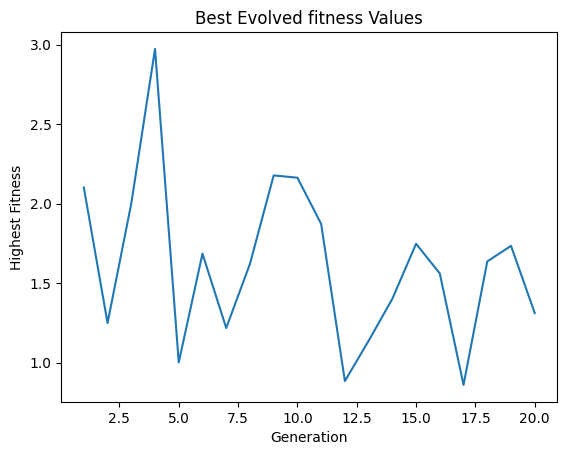

<Figure size 640x480 with 0 Axes>

In [7]:
evolution("geodude.xml", 20, 20, 5000)

In [6]:
#if __name__ == "__main__":
    #evolution("geodude.xml", 10, 100, 5000)